# Boosting
-- Thiago Vieira de Alcantara Silva<br/>
-- 2017719891

On this work, we implemented the Adaptive Boosting algorithm, aka **AdaBoost**, an algorithm proposed by [Freund et al.](https://www.sciencedirect.com/science/article/pii/S002200009791504X)<br/>

For testing the algorithm, I used the [Tic-tac-toe dataset](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame). The dataset is composed by all possible endgames of the tic-tac-toe, assuming that 'x' started.<br/>
The objective of the dataset is to answer whether 'x' won or not.

On this work, we use three libraries:<br/>
<ol>
    <li>**Pandas**. For reading and treating the dataset.</li>
    <li>**Numpy**. For simple operations such as generating an array of zeros.</li>
    <li>**Matplotlib**. For plotting these beautiful charts.</li>
</ol>

The entire AdaBoost algorithm and cross-validation are implemented from scratch.

Note: The random seed is always 42.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from math import log2, fabs, exp
%matplotlib inline

RSEED = 42
np.random.seed(RSEED)

### Reading the dataset...

In [18]:
data = pd.read_csv('tic-tac-toe.data', header=None, delimiter=',')
data.head()

,0,1,2,3,4,5,6,7,8,9
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


### Treating the dataset...

On the following cell, we replace all string values by numerical.<br/>

The x's become 0.<br/>
The o's become 1.<br/>
The b's become 2.<br/>
The positive's become 1.<br/>
The negative's become -1.<br/>

In [19]:
symbol_to_id = {'x':0, 'o':1, 'b':2, 'positive':1, 'negative':-1}
data = data.applymap(lambda x: symbol_to_id[x])
data.describe()

,0,1,2,3,4,5,6,7,8,9
count,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000
mean,0.777662,0.866388,0.777662,0.866388,0.688935,0.866388,0.777662,0.866388,0.777662,0.306889
std,0.775569,0.798966,0.775569,0.798966,0.740882,0.798966,0.775569,0.798966,0.775569,0.952242
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000


## The AdaBoost Class

The AdaBoost class has 6 methods:
<ul>
    <li>**train**: Given a dataset, trains the model and keeps the stumps and alphas in two lists.</li>
    <li>**test**: Given a test set, returns the classifications for each one of the entries.</li>
    <li>**evaluate_model**: Given a dataset, returns the accuracy of the model.</li>
    <li>**classify_stump**: Given a stump and an entry, returns the classification given by the stump.</li>
    <li>**get_best_stump**: Returns the stump with minimum empirical error on the current training set.</li>
    <li>**update_bweights**: Updates the weights of the entries of the training set, given the stump with minimum empirical error.</li>
</ul>


The stumps are quintuples (feature_id, is_x, is_o, is_b, y).<br/>
The interpretation is as follows: Suppose is_x=True, then if the feature[feature_id]='x', classify the entry as 'y', else classify as the opposite of 'y'.<br/>
The same goes for is_o and is_b.<br/>

With this representation, we have 9\*2<sup>4</sup> possible stumps.<br/>
Hence, the *get_best_stump* method just goes through all of them, and returns the one with the highest accuracy.

In [26]:
class AdaBoost():
    def __init__(self):
        pass


    def train(self, data, verbose=False, n_iter=90, min_delta=0.001, patience=10,
              validation=False, validation_set=None):
        '''
            This function trains the model on the data received.
        '''
        self.bweights = [1.0/data.shape[0] for i in range(data.shape[0])]
        self.data = data.values
        self.validation_set = None
        if validation:
            self.validation_set = validation_set.values
        self.alphas = []
        self.stumps = []
        last_accuracy = 0
        cnt_update_accuracy = 0
        train_acc = []
        val_acc = []
        
        while n_iter > 0:
            n_iter -= 1
            best_stump, cur_alpha = self.get_best_stump()
            self.alphas.append(cur_alpha)
            self.stumps.append(best_stump)
            if(self.update_bweights()):
                break
            cur_accuracy = self.evaluate_model(self.data)
            if fabs(cur_accuracy-last_accuracy) < min_delta:
                cnt_update_accuracy += 1
            else:
                last_accuracy = cur_accuracy
                cnt_update_accuracy = 0
            
            train_acc.append(cur_accuracy)
            if validation:
                if not (validation_set is None):
                    val_acc.append(self.evaluate_model(self.validation_set))
            
            if cnt_update_accuracy > patience:
                break
            
            if(verbose):
                if not validation:
                    print('[ #stumps:', len(self.stumps), ' Train Accuracy:', last_accuracy, ']')
                else:
                    print('[ #stumps:', len(self.stumps), ' Train Accuracy:', last_accuracy,
                          ' Validation Accuracy:', val_acc[-1], ']')
        return train_acc, val_acc


    def test(self, test_data):
        '''
            This function runs the model on the data received and returns the classifications.
        '''

        results = []
        for entry in test_data:
            cur_result = 0
            for s_index in range(len(self.stumps)):
                cur_result += self.alphas[s_index]*self.classify_stump(self.stumps[s_index], entry)
            if cur_result < 0:
                results.append(-1)
            else:
                results.append(1)

        return results

    
    def evaluate_model(self, test_data):
        results = self.test(test_data)
        acc = 0
        for i in range(test_data.shape[0]):
            if results[i] == test_data[i][-1]:
                acc += 1
        acc = float(acc) / len(test_data)
        return acc
        

    def classify_stump(self, stump, data_entry):
        '''
            Given a stump and a data entry, this function returns the
            stump's classification.
        '''
        f_value = data_entry[stump[0]]
        if f_value == symbol_to_id['x'] and stump[1]:
            return stump[4]
        elif f_value == symbol_to_id['o'] and stump[2]:
            return stump[4]
        elif f_value == symbol_to_id['b'] and stump[3]:
            return stump[4]
        else:
            return -stump[4]


    def get_best_stump(self):
        '''
            This function gets the stump that minimizes the empirical error,
            and add it to the list of stumps with its alpha value.
        '''
        # (feature_id, x, o, b, -1)
        best_stump = (0, 0, 0, 0, 1)
        best_error = 10000000
        for i in range(9):
            for j in [0, 1]:
                for l in [0, 1]:
                    for m in [0, 1]:
                        for n in [-1, 1]:
                            cur_error = 0
                            cur_stump = (i, j, l, m, n)
                            for k in range(self.data.shape[0]):
                                if self.classify_stump(cur_stump, self.data[k]) != self.data[k][9]:
                                    cur_error += self.bweights[k]
                            if cur_error < best_error:
                                best_error = cur_error
                                best_stump = cur_stump
        alpha = 0.0
        if best_error == 0:
            alpha = 1
        else:
            alpha = log2((1.0-best_error)/best_error)/2.0

        return best_stump, alpha


    def update_bweights(self):
        '''
            ...
        '''
        for i in range(len(self.bweights)):
            exp_sign = self.classify_stump(self.stumps[-1], self.data[i]) * self.data[i][9]
            self.bweights[i] *= exp(-self.alphas[-1]*exp_sign)
        
        z_normalizer = float(sum(self.bweights))
        if (z_normalizer <= 0):
            return True
        for i in range(len(self.bweights)):
            self.bweights[i] /= z_normalizer
        return False
        

## Training the AdaBooost...
In order to set the number of iterations of the algorithm, next we are going to randomly select 20% of the dataset to use as a validation set, the remaining 80% will serve as training.

In [21]:
clf = AdaBoost()

# Randomizing the dataset...
data = data.sample(frac=1, random_state=RSEED).reset_index(drop=True)

val_set = data.iloc[:int(0.2*data.shape[0])]
train_set = data.iloc[int(0.2*data.shape[0]):]

train_acc, val_acc = clf.train(data, verbose=True, n_iter=200, validation=True, validation_set=val_set)

[ #stumps: 1  Train Accuracy: 0.6993736951983298  Validation Accuracy: 0.6858638743455497 ]
[ #stumps: 2  Train Accuracy: 0.6993736951983298  Validation Accuracy: 0.6858638743455497 ]
[ #stumps: 3  Train Accuracy: 0.6388308977035491  Validation Accuracy: 0.6544502617801047 ]
[ #stumps: 4  Train Accuracy: 0.7004175365344467  Validation Accuracy: 0.7120418848167539 ]
[ #stumps: 5  Train Accuracy: 0.744258872651357  Validation Accuracy: 0.7539267015706806 ]
[ #stumps: 6  Train Accuracy: 0.7192066805845512  Validation Accuracy: 0.7172774869109948 ]
[ #stumps: 7  Train Accuracy: 0.6878914405010439  Validation Accuracy: 0.6910994764397905 ]
[ #stumps: 8  Train Accuracy: 0.7265135699373695  Validation Accuracy: 0.7539267015706806 ]
[ #stumps: 9  Train Accuracy: 0.744258872651357  Validation Accuracy: 0.7958115183246073 ]
[ #stumps: 10  Train Accuracy: 0.7588726513569938  Validation Accuracy: 0.7853403141361257 ]
[ #stumps: 11  Train Accuracy: 0.7630480167014614  Validation Accuracy: 0.7958115

[ #stumps: 90  Train Accuracy: 0.9822546972860126  Validation Accuracy: 0.9738219895287958 ]
[ #stumps: 91  Train Accuracy: 0.9822546972860126  Validation Accuracy: 0.9633507853403142 ]
[ #stumps: 92  Train Accuracy: 0.9801670146137788  Validation Accuracy: 0.9633507853403142 ]
[ #stumps: 93  Train Accuracy: 0.9791231732776617  Validation Accuracy: 0.9685863874345549 ]
[ #stumps: 94  Train Accuracy: 0.9770354906054279  Validation Accuracy: 0.9633507853403142 ]
[ #stumps: 95  Train Accuracy: 0.9770354906054279  Validation Accuracy: 0.9633507853403142 ]
[ #stumps: 96  Train Accuracy: 0.9801670146137788  Validation Accuracy: 0.9685863874345549 ]
[ #stumps: 97  Train Accuracy: 0.9822546972860126  Validation Accuracy: 0.9685863874345549 ]
[ #stumps: 98  Train Accuracy: 0.9770354906054279  Validation Accuracy: 0.9738219895287958 ]
[ #stumps: 99  Train Accuracy: 0.9791231732776617  Validation Accuracy: 0.9738219895287958 ]
[ #stumps: 100  Train Accuracy: 0.9791231732776617  Validation Accurac

[ #stumps: 178  Train Accuracy: 0.9832985386221295  Validation Accuracy: 0.9738219895287958 ]
[ #stumps: 179  Train Accuracy: 0.9832985386221295  Validation Accuracy: 0.9685863874345549 ]
[ #stumps: 180  Train Accuracy: 0.9832985386221295  Validation Accuracy: 0.9685863874345549 ]
[ #stumps: 181  Train Accuracy: 0.9832985386221295  Validation Accuracy: 0.9685863874345549 ]
[ #stumps: 182  Train Accuracy: 0.9822546972860126  Validation Accuracy: 0.9633507853403142 ]
[ #stumps: 183  Train Accuracy: 0.9822546972860126  Validation Accuracy: 0.9685863874345549 ]
[ #stumps: 184  Train Accuracy: 0.9832985386221295  Validation Accuracy: 0.9685863874345549 ]
[ #stumps: 185  Train Accuracy: 0.9832985386221295  Validation Accuracy: 0.9685863874345549 ]
[ #stumps: 186  Train Accuracy: 0.9832985386221295  Validation Accuracy: 0.9685863874345549 ]
[ #stumps: 187  Train Accuracy: 0.9832985386221295  Validation Accuracy: 0.9685863874345549 ]
[ #stumps: 188  Train Accuracy: 0.9822546972860126  Validati

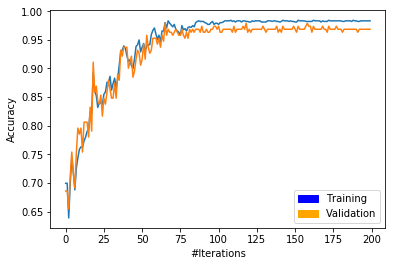

In [22]:
plt.plot(np.arange(len(train_acc)), train_acc, np.arange(len(val_acc)), val_acc)
blue_patch = mpatches.Patch(color='blue', label='Training')
orange_patch = mpatches.Patch(color='orange', label='Validation')
plt.legend(handles=[blue_patch, orange_patch])
plt.ylabel('Accuracy')
plt.xlabel('#Iterations')
plt.show()

The training accuracy crosses the validation accuracy around the 80<sup>th</sup> iteration.<br/>
Since the algorithm stabilizes around the 90<sup>th</sup> iteration, we then set the number of iterations to 90.

## Evaluating the AdaBoost
In order to evaluate the results of the algorithm, we implement a 5-fold cross-validation. For each fold, we present a chart showing the evolution of the training accuracy. And we conclude showing the average accuracy of the model for the Tic-Tac-Toe dataset.

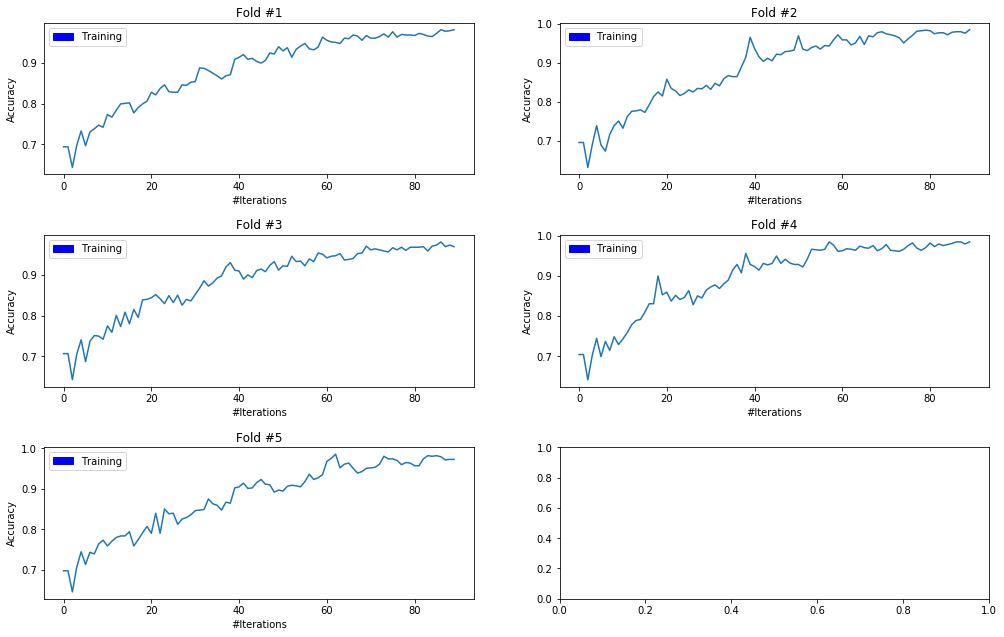

In [36]:
f, pltarr = plt.subplots(3, 2)

plt.subplots_adjust(bottom=0.1, right=1, top=0.9, hspace=0.4)
f.set_figheight(10)
f.set_figwidth(15)

# Randomizing the dataset...
data = data.sample(frac=1, random_state=RSEED).reset_index(drop=True)

fold_cnt = 1
test_acc = []
i=0
j=-1

step = int(0.2*data.shape[0])
for fold in range(0, data.shape[0], step):
    clf = AdaBoost()
    
    # Ignoring the extra loop...
    if fold+step > data.shape[0]:
        continue
    
    test_set = data.iloc[fold:fold+step]
    train_set = data.iloc[np.r_[0:fold, (fold+step):data.shape[0]]]
    train_acc, garbage = clf.train(train_set, verbose=False)
    test_acc.append(clf.evaluate_model(test_set.values))
    
    if(j == 1):
        i += 1
        j = 0
    else:
        j += 1
    
    pltarr[i, j].plot(np.arange(len(train_acc)), train_acc)
    pltarr[i, j].set_title('Fold #%d' % fold_cnt)
    blue_patch = mpatches.Patch(color='blue', label='Training')
    pltarr[i, j].legend(handles=[blue_patch])
    pltarr[i, j].set(xlabel='#Iterations', ylabel='Accuracy')

    fold_cnt += 1

plt.show()

In [42]:
print('Test Accuracy for each fold:\n', test_acc, '\n')
print('Average Test Accuracy:', np.mean(test_acc))
print('Standard Deviation of Test Accuracy:', np.std(test_acc))

Test Accuracy for each fold:
 [0.9842931937172775, 0.9790575916230366, 0.9738219895287958, 0.9685863874345549, 0.9633507853403142] 

Average Test Accuracy: 0.9738219895287958
Standard Deviation of Test Accuracy: 0.00740425948886438


## Conclusion
The Learning curves presented above indicate that the algorithm reaches its maximum accuracy right before stopping.<br/>
As reported above, the average test accuracy is around 97.4%, and the standard deviation is really small.